In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import json
from pathlib import Path
from typing import *
from functools import partial
sns.set_context("notebook")

In [2]:
def load(path: str) -> pd.DataFrame:
    def _load_line(d: Dict[str, Any]) -> Dict[str, Any]:
        for key in ["task", "sparsity", "execution", "wandb"]:
            d.update({f"{key}_{k}": v for k, v in d.pop(key).items()})
        return d
    return pd.DataFrame.from_dict([_load_line(json.loads(line)) for line in Path(path).open()])

(load("data/raw_v2.jsonl")
    .drop(columns=["results"])
    .to_json("summary.json"))

In [3]:
def technique(s: pd.Series) -> str:
    if s.sparsity_name == "eviction":
        return f"eviction({s.sparsity_local_k/s.sparsity_k:.0%} local)"
    if s.sparsity_name == "sparse_v":
        if not s.sparsity_apply_after_softmax:
            return "sparse_v(topk before)"
        if s.sparsity_add_avg:
            return "sparse_v(topk after + avg)"
        return "sparse_v(topk after)"
    return s.sparsity_name

df = (pd.read_json("summary.json")
    .drop(columns=["name", "code_changes", "count", "duration", "task_shots", "task_samples",
                   "wandb_id", "wandb_name", "wandb_url", "execution_device", "execution_dtype", "execution_batch_size", "execution_wandb"])
    .pipe(lambda d: d.assign(model_scale=d.model.map(lambda s: s.replace("EleutherAI/pythia-", ""))))
    .pipe(lambda d: d.assign(technique=d.apply(technique, axis=1)))
    .pipe(lambda d: d.assign(score=d.apply(lambda s: s.match if np.isnan(s.rougeL) else s.rougeL, axis=1)))
)
df.head()

,model,parameters,prefill_length,match,task_name,sparsity_name,sparsity_k,sparsity_local_k,sparsity_apply_after_softmax,sparsity_add_avg,reference_length,rougeL,model_scale,technique,score
0,EleutherAI/pythia-1b,1011781632,1411.755,0.411,squad,dense,NaN,NaN,NaN,NaN,NaN,NaN,1b,dense,0.411
1,EleutherAI/pythia-1b,1011781632,1411.755,0.095,squad,eviction,32.0,8.0,NaN,NaN,NaN,NaN,1b,eviction(25% local),0.095
2,EleutherAI/pythia-1b,1011781632,1411.755,0.095,squad,eviction,32.0,16.0,NaN,NaN,NaN,NaN,1b,eviction(50% local),0.095
3,EleutherAI/pythia-1b,1011781632,1411.755,0.164,squad,sparse_v,32.0,NaN,0.0,0.0,NaN,NaN,1b,sparse_v(topk before),0.164
4,EleutherAI/pythia-1b,1011781632,1411.755,0.298,squad,sparse_v,32.0,NaN,1.0,0.0,NaN,NaN,1b,sparse_v(topk after),0.298


/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


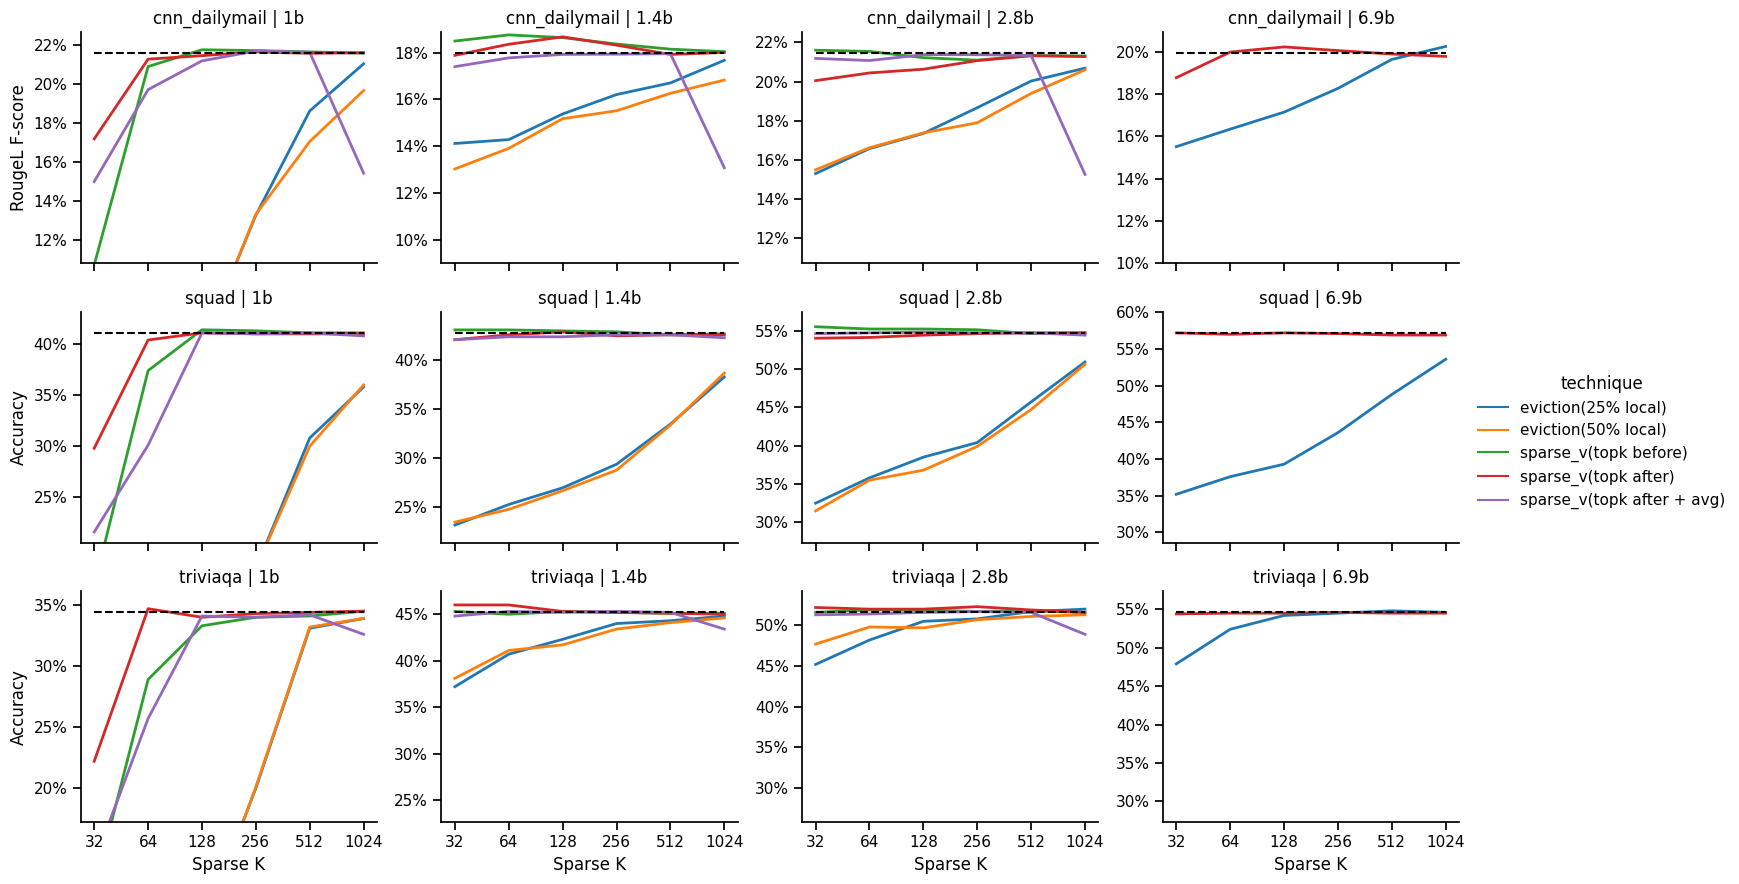

In [4]:
g = sns.relplot(data=df.pipe(lambda d: d[d.technique != "dense"]),
                y="score", x="sparsity_k", hue="technique",
                row="task_name", row_order=["cnn_dailymail", "squad", "triviaqa"],
                col="model_scale", col_order=["1b", "1.4b", "2.8b", "6.9b"],
                kind="line", facet_kws=dict(sharey=False), height=3, aspect=1.25, lw=2)

for (dataset, model_scale), d in df.pipe(lambda d: d[d.technique == "dense"]).groupby(["task_name", "model_scale"]):
    if (dataset, model_scale) in g.axes_dict:
        ax = g.axes_dict[(dataset, model_scale)]
        ax.set_title(f"{dataset} | {model_scale}")
        ax.hlines(d.score, 32, 1024, "k", linestyle="dashed", label="dense baseline")
        if ax.get_xlabel():
            ax.set_xlabel("Sparse K")
        ax.set_xscale("log", base=2)
        ax.set_xticks([2**n for n in range(5, 11)])
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        if ax.get_ylabel():
            ax.set_ylabel("RougeL F-score" if dataset == "cnn_dailymail" else "Accuracy")
        ax.set_ylim((0.5 * d.score.item(), 1.05 * d.score.item()))
        ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))

# Tradeoff curves

/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


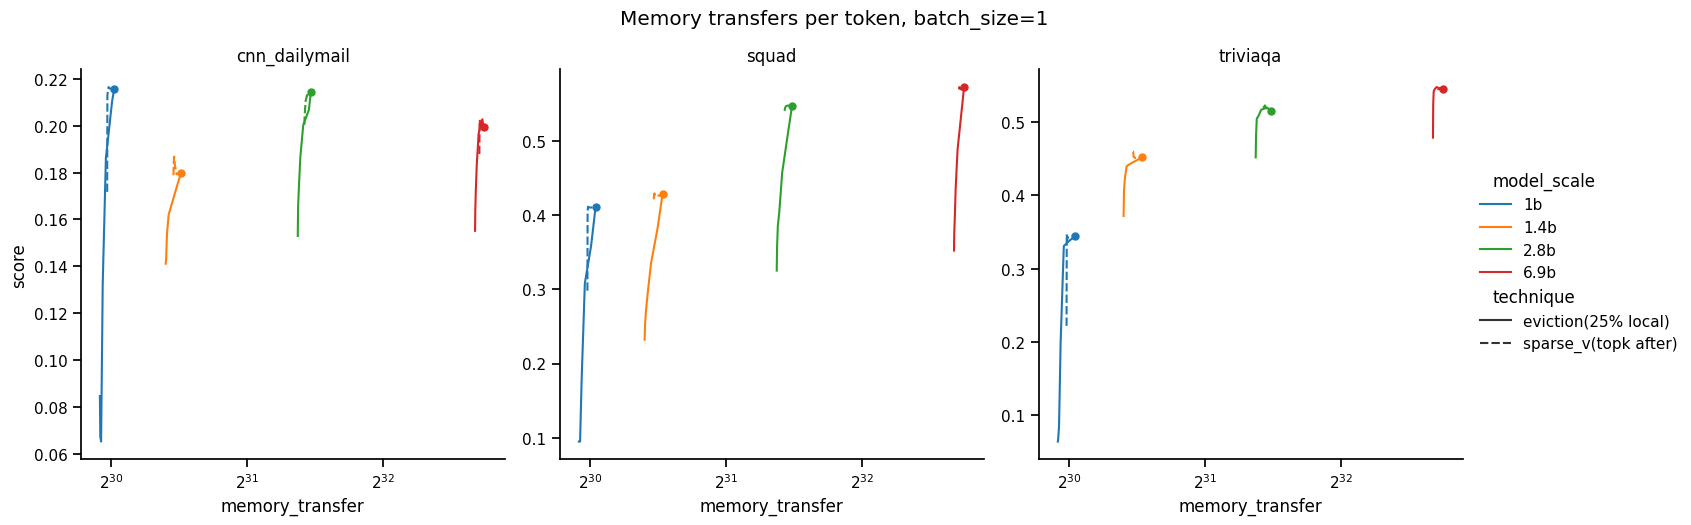

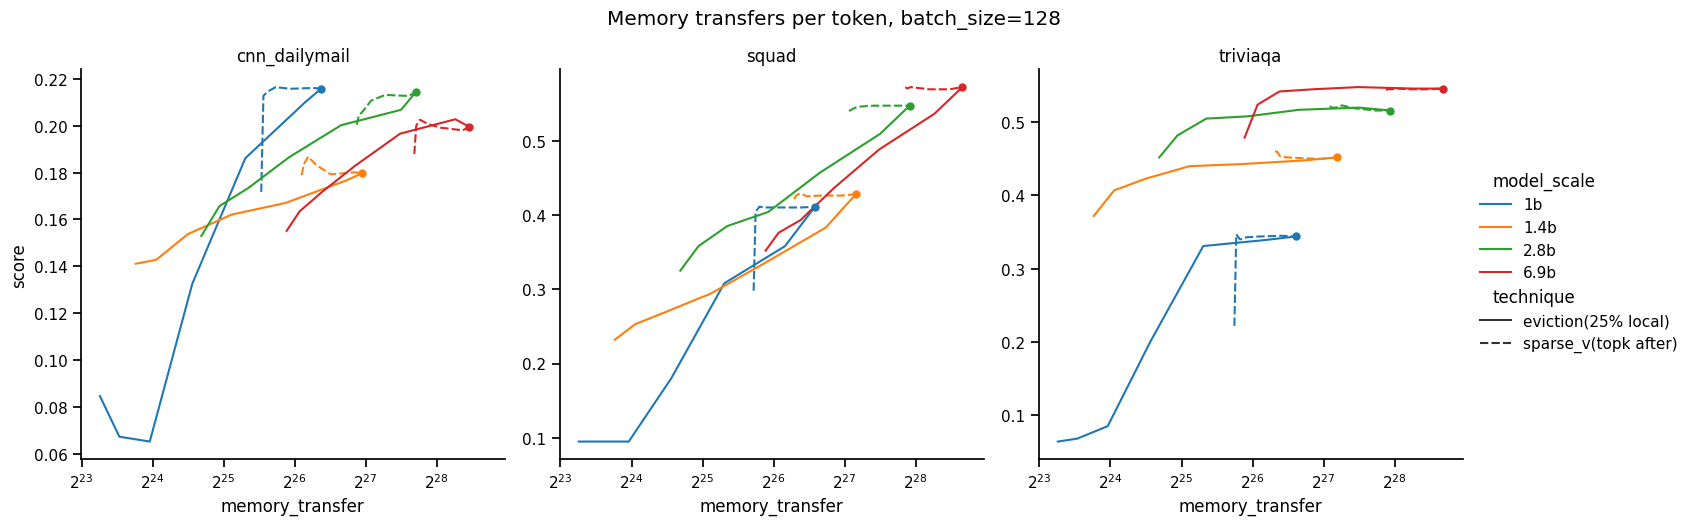

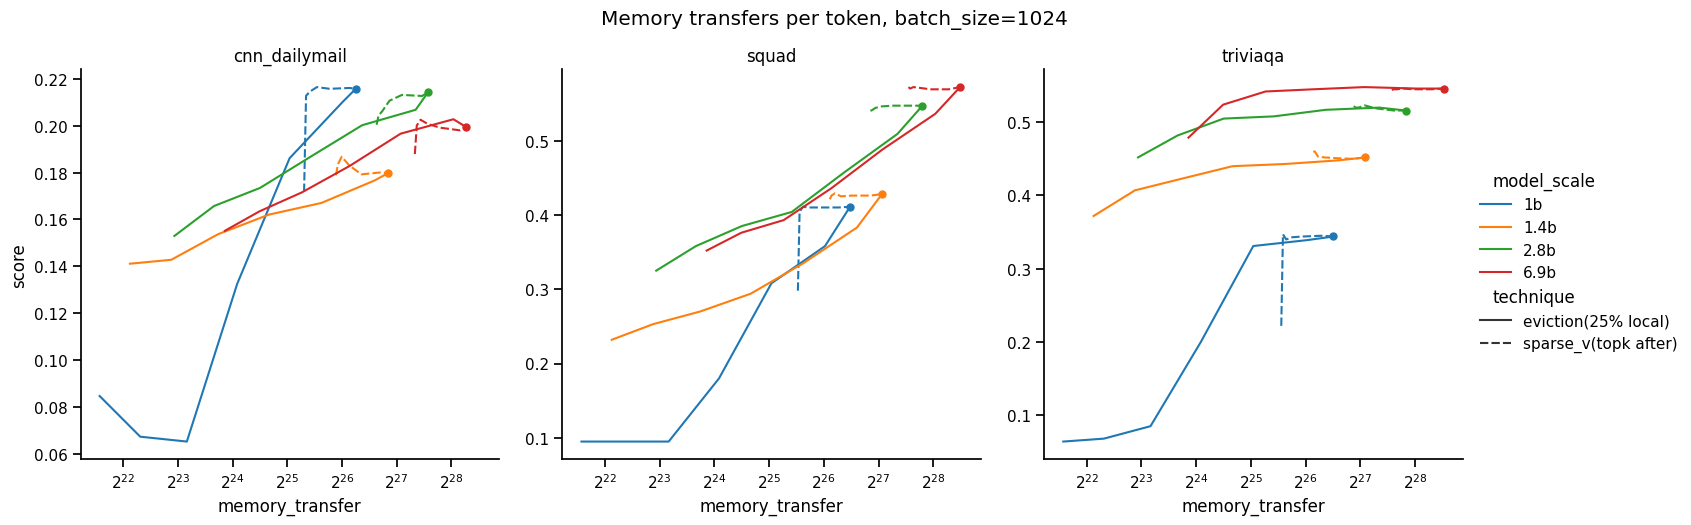

In [5]:
def add_dense_as_sparse_technique(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'technique' string.
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g.technique=="dense"]
        assert len(g_dense) == 1
        return (g.groupby("technique")
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(technique=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task_name", "model_scale"]).apply(_map).reset_index(drop=True)

def get_memory_transfer(s: pd.Series, batch_size: int) -> float:
    if s.sparsity_name == "dense":
        nkv = 1 + 2 * s.prefill_length  # write current + read all KVs
    if s.sparsity_name == "sparse_v":
        nkv = 1 + s.prefill_length + s.sparsity_k + 2 * s.sparsity_add_avg
    if s.sparsity_name == "eviction":
        nkv = 1 + 2 * s.sparsity_k
    hidden_size = {"1b": 2048, "1.4b": 2048, "2.8b": 2560, "6.9b": 4096}[s.model_scale]
    n_layers = {"1b": 16, "1.4b": 24, "2.8b": 32, "6.9b": 32}[s.model_scale]
    return nkv * hidden_size * n_layers + s.parameters / batch_size

model_scales = ["1b", "1.4b", "2.8b", "6.9b"]
for batch_size in [1, 128, 1024]:
    d = (df.pipe(lambda d: d.assign(memory_transfer=d.apply(partial(get_memory_transfer, batch_size=batch_size), axis=1)))
        .pipe(lambda d: d[d.technique.isin(["dense", "eviction(25% local)", "sparse_v(topk after)"])])
        .pipe(add_dense_as_sparse_technique))
    g = sns.relplot(
        data=d[d.technique!="dense"].sort_values("task_name"),
        y="score", x="memory_transfer", col="task_name",
        hue="model_scale", hue_order=model_scales, style="technique",
        kind="line", facet_kws=dict(sharey=False), height=5)
    plt.suptitle(f"Memory transfers per token, batch_size={batch_size}", y=1.04)
    for task, baseline in d[d.technique=="dense"].groupby("task_name"):
        ax = g.axes_dict[task]
        for color, model_scale in zip(sns.color_palette(), model_scales):
            b = baseline[baseline.model_scale == model_scale]
            if len(b):
                ax.plot(b.memory_transfer.item(), b.score.item(), 'o', ms=5, color=color)
        ax.set_title(task)
        ax.set_xscale("log", base=2)